A hydrostatic, inviscid, adiabatic, and dry system in isentropic coordinates
==

In [1]:
from datetime import timedelta
import gridtools as gt
import numpy as np
import tasmania as taz

# For interactive plotting
from IPython import display
%matplotlib nbagg

Load the computational grid and the initial state
--

In [2]:
grid, states = taz.load_netcdf_dataset('../tests/baseline_datasets/isentropic_dry.nc')
state = states[0]

Instantiate the physical packages
--

In [3]:
# The component retrieving the diagnostic variables
pt = state['air_pressure_on_interface_levels'][0, 0, 0]
dv = taz.IsentropicDiagnostics(grid, moist_on=False, pt=pt, backend=gt.mode.NUMPY, dtype=np.float32)

# The component calculating the pressure gradient in isentropic coordinates
pg = taz.NonconservativeIsentropicPressureGradient(grid, order=4, horizontal_boundary_type='relaxed',
                                                   backend=gt.mode.NUMPY, dtype=np.float32)

# Wrap the components in a ConcurrentCoupling object
cc = taz.ConcurrentCoupling(dv, pg, mode='serial')

Instantiate the dynamical core
--

In [4]:
# Adopt the flux form of the three-stages Runge-Kutta time integration method,
# coupled with a fifth-order upwind advection scheme
dycore = taz.HomogeneousIsentropicDynamicalCore(grid, moist_on=False,
                                                time_integration_scheme='rk3cosmo',
                                                horizontal_flux_scheme='fifth_order_upwind',
                                                horizontal_boundary_type='relaxed',
                                                intermediate_parameterizations=cc,
                                                damp_on=True, damp_type='rayleigh', damp_depth=15,
                                                damp_max=0.0002, damp_at_every_stage=False,
                                                smooth_on=True, smooth_type='third_order',
                                                smooth_coeff=0.24, smooth_at_every_stage=False,
                                                backend=gt.mode.NUMPY, dtype=np.float32)

Create a monitor for interactive visualization
--

In [5]:
# The artist and its collaborators generating the left subplot
coll1 = taz.Plot2d(grid, plot_function=taz.make_contourf_xy, 
                   field_to_plot='horizontal_velocity', level=-1,
                   plot_function_kwargs={'fontsize': 16, 
                                         'x_factor': 1e-3, 'y_factor': 1e-3,
                                         'cmap_name': 'BuRd', 'cbar_on': True, 
                                         'cbar_levels': 16, 'cbar_ticks_step': 2, 
                                         'cbar_center': 15, 'cbar_half_width': 7.5,
                                         'cbar_orientation': 'horizontal',
                                         'cbar_x_label': 'Horizontal velocity [m s$^{-1}$]'})
coll2 = taz.Plot2d(grid, plot_function=taz.make_quiver_xy, 
                   field_to_plot='horizontal_velocity', level=-1, 
                   plot_function_kwargs={'fontsize': 16, 
                                         'x_factor': 1e-3, 'x_step': 2,
                                         'y_factor': 1e-3, 'y_step': 2})
subplot1 = taz.PlotsOverlapper((coll1, coll2), fontsize=16, 
                               plot_properties={'fontsize': 16,
                                                'title_left': '$\\theta = 300$ K',
                                                'x_label': '$x$ [km]', 'x_lim': [0, 500],
                                                'y_label': '$y$ [km]', 'y_lim': [-250, 250]})

# The artist generating the right subplot
subplot2 = taz.Plot2d(grid, plot_function=taz.make_contourf_xz, 
                      field_to_plot='x_velocity_at_u_locations', level=25, fontsize=16, 
                      plot_properties={'fontsize': 16, 'title_left': '$y = 0$ km',
                                       'x_label': '$x$ [km]', 'x_lim': [0, 500],
                                       'y_label': '$z$ [km]', 'y_lim': [0, 14]},
                      plot_function_kwargs={'fontsize': 16, 
                                            'x_factor': 1e-3, 'z_factor': 1e-3,
                                            'cmap_name': 'BuRd', 'cbar_on': True, 
                                            'cbar_levels': 16, 'cbar_ticks_step': 2, 
                                            'cbar_center': 15, 'cbar_half_width': 7.5,
                                            'cbar_orientation': 'horizontal',
                                            'cbar_x_label': '$x$-velocity [m s$^{-1}$]'})

# The monitor encompassing and coordinating the two artists
monitor = taz.SubplotsAssembler(nrows=1, ncols=2, artists=(subplot1, subplot2), 
                                interactive=False, figsize=(12, 7), fontsize=16, 
                                tight_layout=True)

Run the simulation
--

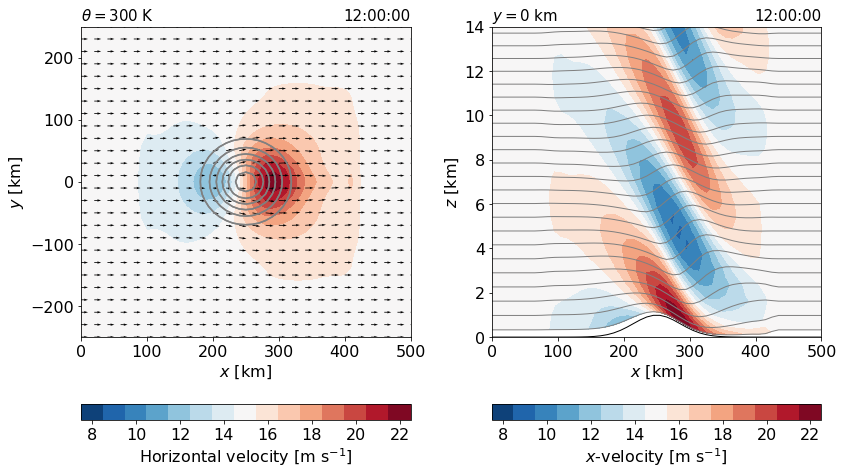

Simulation successfully completed. HOORAY!


In [6]:
# Simulation settings
timestep = timedelta(seconds=24)
niter    = 1800

for i in range(niter):
    # Update the (time-dependent) topography
    dycore.update_topography((i+1)*timestep)
    
    # Step the solution
    state_new = dycore(state, {}, timestep)
    state.update(state_new)

    if (i+1) % 30 == 0:
        # Retrieve the diagnostics variables
        diagnostics = dv(state)
        state.update(diagnostics)
        
        # Plot the solution
        subplot1.plot_properties['title_right'] = str((i+1)*timestep)
        subplot2.plot_properties['title_right'] = str((i+1)*timestep)
        fig = monitor.store(((state, state), state), show=False)
        display.clear_output(wait=True)
        display.display(fig)
        
print('Simulation successfully completed. HOORAY!')